In [15]:
import os
import argparse
import json
import sys

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

sys.path.append(os.path.abspath(os.path.join("..", "..", "..")))  # without installation, add /path/to/Audio-ZEN
from from_asteroid.models import ConvTasNet
from audio_zen.dataset.edinburgh_dataset import Edingburgh
from audio_zen.optimizers import make_optimizer
from audio_zen.system import System
from from_asteroid.losses import PITLossWrapper, pairwise_neg_sisdr, singlesrc_mse


parser = argparse.ArgumentParser()
parser.add_argument("--exp_dir", default="exp/tmp", help="Full path to save best validation model")

conf = {'positional arguments': {}, 
        'filterbank': {'n_filters': 512, 'kernel_size': 16, 'stride': 8}, 
        'masknet':    {'n_blocks': 8, 'n_repeats': 3, 'mask_act': 'relu', 'bn_chan': 128, 'skip_chan': 128, 'hid_chan': 512, 'n_src': 1}, 
        'training':   {'epochs': 100, 'batch_size': 8, 'num_workers': 4, 'half_lr': True, 'early_stop': True},
        'optim':      {'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0}, 
        'data':       {'target_sr': 8000, 'segment': 2,
                       'train_path': "edingburgh_meta/edingburgh_train_meta.csv",
                       'valid_path': "edingburgh_meta/edingburgh_valid_meta.csv"}, 
        'main_args':  {'help': None, 'exp_dir': 'exp/train_convtasnet_yyds'}
        }

In [16]:
train_set = Edingburgh(
    csv_path=conf["data"]["train_path"],
    target_sr=conf["data"]["target_sr"],
    segment=conf["data"]["segment"],
)

val_set = Edingburgh(
    csv_path=conf["data"]["valid_path"],
    target_sr=conf["data"]["target_sr"],
    segment=conf["data"]["segment"],
)

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=conf["training"]["batch_size"],
    num_workers=conf["training"]["num_workers"],
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    shuffle=False,
    batch_size=conf["training"]["batch_size"],
    num_workers=conf["training"]["num_workers"],
    drop_last=True,
)

Drop 2373 utterances from 23075 (shorter than 2 seconds)
Drop 2373 utterances from 23075 (shorter than 2 seconds)


In [17]:
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

wav_id = 10

first_noisy = train_set[wav_id][0].numpy().flatten()
first_clean = train_set[wav_id][1].numpy().flatten()

In [18]:
sr = 16000
Audio(first_noisy.astype(np.float32), rate=sr)

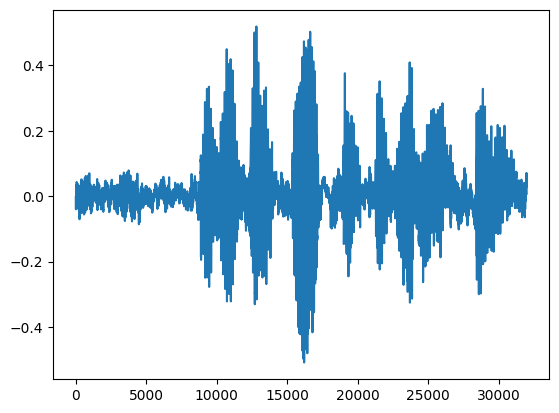

In [9]:
plt.plot(first_noisy)
plt.show()

In [ ]:
import yaml

In [ ]:
model = ConvTasNet(**conf["filterbank"], **conf["masknet"], sample_rate=conf["data"]["target_sr"])      # The sample_rate here is the expected input audio sample rate
optimizer = make_optimizer(model.parameters(), **conf["optim"])

# Define scheduler
scheduler = None
if conf["training"]["half_lr"]:
    scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)
# Just after instantiating, save the args. Easy loading in the future.
exp_dir = conf["main_args"]["exp_dir"]
os.makedirs(exp_dir, exist_ok=True)
conf_path = os.path.join(exp_dir, "conf.yml")
with open(conf_path, "w") as outfile:
    yaml.safe_dump(conf, outfile)

# Define Loss function.
loss_func = PITLossWrapper(pairwise_neg_sisdr, pit_from='pw_mtx')    #PITLossWrapper(singlesrc_mse, pit_from="pw_pt")  #FIXME 
system = System(
    model=model,
    loss_func=loss_func,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    config=conf,                # The conf dict passed to a "System" object is just for the hyperparameters storage
)

# Define callbacks
callbacks = []
checkpoint_dir = os.path.join(exp_dir, "checkpoints/")
checkpoint = ModelCheckpoint(
    checkpoint_dir, monitor="val_loss", mode="min", save_top_k=5, verbose=True
)
callbacks.append(checkpoint)
if conf["training"]["early_stop"]:
    callbacks.append(EarlyStopping(monitor="val_loss", mode="min", patience=30, verbose=True))

trainer = pl.Trainer(
    max_epochs=conf["training"]["epochs"],
    callbacks=callbacks,
    default_root_dir=exp_dir,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    strategy="ddp_find_unused_parameters_true",
    devices='auto',              # Using GPU device 1
    limit_train_batches=1.0,  # Useful for fast experiment
    gradient_clip_val=5.0,
)
trainer.fit(system)

best_k = {k: v.item() for k, v in checkpoint.best_k_models.items()}
with open(os.path.join(exp_dir, "best_k_models.json"), "w") as f:
    json.dump(best_k, f, indent=0)

state_dict = torch.load(checkpoint.best_model_path)
system.load_state_dict(state_dict=state_dict["state_dict"])
system.cpu()

to_save = system.model.serialize()
to_save.update(train_set.get_infos())
torch.save(to_save, os.path.join(exp_dir, "best_model.pth"))

In [ ]:
def main(conf):
    pass


if __name__ == "__main__":
    import yaml
    from pprint import pprint
    from from_asteroid.utils import prepare_parser_from_dict, parse_args_as_dict

    # We start with opening the config file conf.yml as a dictionary from
    # which we can create parsers. Each top level key in the dictionary defined
    # by the YAML file creates a group in the parser.
    with open("local/conf.yml") as f:
        def_conf = yaml.safe_load(f)
    parser = prepare_parser_from_dict(def_conf, parser=parser)
    # Arguments are then parsed into a hierarchical dictionary (instead of
    # flat, as returned by argparse) to facilitate calls to the different
    # asteroid methods (see in main).
    # plain_args is the direct output of parser.parse_args() and contains all
    # the attributes in an non-hierarchical structure. It can be useful to also
    # have it so we included it here but it is not used.
    arg_dic, plain_args = parse_args_as_dict(parser, return_plain_args=True)
    pprint(arg_dic)
    main(arg_dic)
    # pprint(conf)
    # main(conf)

